# e.g. 12: Compare monthly nino34 time-series from daily/monthly inputs from 1 forecast run & assim & ETKF & control & 2 observations

# last edited 25 July 2018

# to be run on vm32 (or potentially any machine including raijin)

# 1.  first major JN cell does computations 2. second major JN cell pickles data objects, optionally writes them out, and reads them back in, and plots them.

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [1]:
print('BEGIN')

###

import socket
import re
import os
import sys
import inspect
import pickle
import glob

print('sys.version=',sys.version)

hostname=socket.gethostname()

print('hostname=',hostname)

__file__='jupyter_notebook' #this can be deleted when written to a python script and loaded as module.

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import numpy as np
import numpy.ma as ma
from matplotlib.mlab import griddata

from decadal_diag import \
  fractional_year_from_num2date, \
  generate_daily_month_indices, \
  shade_2d_latlon, \
  get_timestamp_number, \
  shade_2d_curvilinear, \
  shade_2d_simple, \
  nino_indices, \
  plot_xy, \
  fractional_year_from_num2date

from n_data_funcs import n_data_funcs
  
cafe_experiment_titles = {1:'v0_forecast', 4:'v1_forecast', 3:'v2_forecast', 9:'v1', \
  5:'v2', 6:'v3', 7:'aug17p', 2:'v1_assim', 10:'etkf'}

nino_index_k=0

max_ensemble=3 #this will utilise first two ensembles.
#max_ensemble=2 #this will utilise first ensemble (could be issues as array's might collapse...)
max_ensemble=11 #this utilise give all ensembles.

%matplotlib inline

CRED = '\033[91m'
CEND = '\033[0m'

print('END')

BEGIN
sys.version= 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
hostname= oa-32-cdc
END


In [ ]:
# import netCDF4
# import shutil
# from nco import Nco
# from cdo import *

# # on raijin:
# # ncks -A -v time_bnds /short/v14/mac599/ncep2/prate.sfc.gauss.1982.nc /short/v14/mac599/ncep2/skt.sfc.gauss.1982.nc


# #https://code.mpimet.mpg.de/projects/cdo/wiki/Cdo%7Brbpy%7D
  
# print('Current Working Directory=',os.getcwd())

# #os.environ['APP_OUTPATH'] = '.'
# print(os.getenv('LD_LIBRARY_PATH'))

# #ncks -A -v time_bnds prate.sfc.gauss.1982.nc test.nc

# shutil.copy('/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1982.nc','test.nc')

# cdo = Cdo()

# #help(cdo.sinfov)


# # nco = Nco()
# # nco.ncks(input='/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/prate.sfc.gauss.1982.nc', output='test.nc', variable='time_bnds', options=('-A'))

# #https://groups.google.com/a/continuum.io/forum/#!topic/conda/-5Sn2z5snPs
# #/OSM/CBR/OA_DCFP/work/col414$ ls /OSM/CBR/OA_DCFP/apps/col414/anaconda3/envs/cafepp_27_scipy/lib/

# # ifils=[['/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1980.nc', \
# #  '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1981.nc']]
# # ifils=[['/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1980.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1981.nc','/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1982.nc','/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1983.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1984.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1985.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1986.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1987.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1988.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1989.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1990.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1991.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1992.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1993.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1994.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1995.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1996.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1997.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1998.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1999.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2000.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2001.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2002.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2003.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2004.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2005.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2006.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2007.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2008.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2009.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2010.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2011.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2012.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2013.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2014.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2015.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2016.nc', '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.2017.nc']]
# #         #, '/OSM/CBR/OA_DCFP/data/CAFEPP/short/v14/mac599/ncep2/skt.sfc.gauss.1982.nc']]
# # ifhN=netCDF4.MFDataset(ifils[0][:])

# print('END')

In [ ]:
print('BEGIN')

import socket
import re
import os
import sys

print('sys.version=',sys.version)

hostname=socket.gethostname()

print('hostname=',hostname)

if(re.match('raijin',hostname)):
  print('this is rajin')
  rundir='/short/v14/mac599/cafepp/rundir'
  topdir=''
elif(re.match('oa-32-cdc',hostname)):
  print('this is vm32')
  rundir='/OSM/CBR/OA_DCFP/work/col414/cafepp'
  topdir='/OSM/CBR/OA_DCFP/data/CAFEPP/CMIP6'
  topdir_ncep='/OSM/CBR/OA_DCFP/data/CAFEPP/'

os.chdir(rundir)

os.chdir('/OSM/CBR/OA_DCFP/work/col414/cafepp')

print('Current Working Directory=',os.getcwd())

SWITCH_OFF=True #temporary for easy skipping of this section.
SWITCH_OFF=False

if(not SWITCH_OFF):
  
#===============================================================================

  product='ncepr2'

  ivar_str_ncepr2='skt';ifil_prefix_ncepr2='skt';offset=0.0;scale=1.0;long_name='Surface Temperature';units='degC'

  grid_label='ncep_r1'
  ncepr2_calendar='proleptic_gregorian'

  #monthly inputs
  idir=topdir_ncep+'short/r67/mac599/data/NCEP_R1'
  ncepr2_monthly_files=[[idir+'/'+ifil_prefix_ncepr2+'.mon.mean.nc']]
    
  #daily inputs
  idir=topdir_ncep+'short/v14/mac599/ncep2'
  ncepr2_daily_files=[sorted( \
    glob.glob(idir+'/'+ifil_prefix_ncepr2+'.sfc.gauss.197?.nc')+ \
    glob.glob(idir+'/'+ifil_prefix_ncepr2+'.sfc.gauss.198?.nc')+ \
    glob.glob(idir+'/'+ifil_prefix_ncepr2+'.sfc.gauss.199?.nc')+ \
    glob.glob(idir+'/'+ifil_prefix_ncepr2+'.sfc.gauss.200?.nc')+ \
    glob.glob(idir+'/'+ifil_prefix_ncepr2+'.sfc.gauss.201?.nc') \
    )]
  
  print('ncepr2_monthly_files=',ncepr2_monthly_files)
  print('ncepr2_daily_files=',ncepr2_daily_files)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================

  product='HadISST'

  ivar_str_hadisst='tos';ifil_prefix_hadisst='tos';offset=273.15;scale=1.0;long_name='Surface Temperature';units='degC'

  grid_label='hadisst'
  hadisst_calendar='proleptic_gregorian'

  hadisst_files=[]
  idir=topdir_ncep+'g/data/r67/CMIP5/common_restricted/CMIP5/output/Hadley/HadISST/1d/mon/ocean/Omon/r1i1p1/v20170110/tos'
  ifils=[ifil_prefix_hadisst+'_Omon_HadISST_1d_r1i1p1_187001-201512.nc']
  for file in ifils:
    if(not os.path.exists(idir+'/'+file)):
      raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
    else:
      hadisst_files.append(idir+'/'+file)  
  hadisst_files=[hadisst_files]

  print('hadisst_files=',hadisst_files)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#==============================================================================
  model='CAFE'
  
  grid_label='gn'
  cafe_calendar='julian'
      
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Oday'

  pval=10 #etkf
  cafe_daily_files_etkf=[]
  for ensemble in range(2,max_ensemble+1):
    cafe_inner_daily_files_etkf=[]
    idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
      '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
    daily_ifils_etkf=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
      grid_label+'_20030101-20091231.nc']
    for file in daily_ifils_etkf:
      if(not os.path.exists(idir+'/'+file)):
        raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
      else:
        cafe_inner_daily_files_etkf.append(idir+'/'+file)
    cafe_daily_files_etkf.append(cafe_inner_daily_files_etkf)

  print('cafe_daily_files_etkf=',cafe_daily_files_etkf)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================
  
  model='CAFE'
  nino_index_k=0
  
  grid_label='gn'
  cafe_calendar='julian'
    
  cafe_experiment_titles = {1:'v0_forecast', 4:'v1_forecast', 3:'v2_forecast', 9:'v1', 5:'v2', 6:'v3', 7:'aug17p'}
  
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Oday'

  pval=1 #v1_forecast
  cafe_daily_files_v1forc=[]
  for ensemble in range(2,max_ensemble+1):
    cafe_inner_daily_files_v1forc=[]
    idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
      '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
    daily_ifils_v1forc=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
      grid_label+'_20070101-20121231.nc']
    for file in daily_ifils_v1forc:
      if(not os.path.exists(idir+'/'+file)):
        raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
      else:
        cafe_inner_daily_files_v1forc.append(idir+'/'+file)
    cafe_daily_files_v1forc.append(cafe_inner_daily_files_v1forc)

    #note monthly have 1 year less ATM.
    
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Omon'

  pval=1 #v1_forecast
  cafe_monthly_files_v1forc=[]
  for ensemble in range(2,max_ensemble+1):
    cafe_inner_monthly_files_v1forc=[]
    idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
      '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
    monthly_ifils_v1forc=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
      grid_label+'_200701-201212.nc']
    for file in monthly_ifils_v1forc:
      if(not os.path.exists(idir+'/'+file)):
        raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
      else:
        cafe_inner_monthly_files_v1forc.append(idir+'/'+file)
    cafe_monthly_files_v1forc.append(cafe_inner_monthly_files_v1forc)
    
    
  print('cafe_daily_files_v1forc=',cafe_daily_files_v1forc)
  print('cafe_monthly_files_v1forc=',cafe_monthly_files_v1forc)

  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  model='CAFE'
  nino_index_k=0
  
  grid_label='gn'
  cafe_calendar='julian'
    
  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Oday'

  ensemble=1
  pval=2 #v1_assim
  cafe_daily_files_assim=[]
  idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
    '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
  daily_ifils_assim=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
    grid_label+'_20020101-20151231.nc']
  for file in daily_ifils_assim:
    if(not os.path.exists(idir+'/'+file)):
      raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
    else:
      cafe_daily_files_assim.append(idir+'/'+file)
  cafe_daily_files_assim=[cafe_daily_files_assim]

  ivar_str_cafe='tos';offset=0.0;scale=1.0;long_name='Sea Surface Temperature';short_name='SST';units='degC';table='Omon'

  ensemble=1
  pval=2 #v1_assim
  cafe_monthly_files_assim=[]
  idir=topdir+'/'+'CMIP6/CMIP/CSIRO/CAFE-1-0/historical/r'+str(ensemble)+'i1p'+str(pval)+'f1/'+table+ \
    '/'+ivar_str_cafe+'/'+grid_label+'/v20171025'
  monthly_ifils_assim=[ivar_str_cafe+'_'+table+'_historical_CAFE-1-0_r'+str(ensemble)+'i1p'+str(pval)+'f1_'+ \
    grid_label+'_200201-201512.nc']
  for file in monthly_ifils_assim:
    if(not os.path.exists(idir+'/'+file)):
      raise SystemExit(idir+'/'+file+' doesnt exist:'+__file__+' line number: '+str(inspect.stack()[0][2]))
    else:
      cafe_monthly_files_assim.append(idir+'/'+file)
  cafe_monthly_files_assim=[cafe_monthly_files_assim]
  
  
  print('cafe_daily_files_assim=',cafe_daily_files_assim)
  print('cafe_monthly_files_assim=',cafe_monthly_files_assim)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  cbeg_hadisst=1971
  cend_hadisst=2000
  abeg_hadisst=1971
  aend_hadisst=2015

  grid_label='hadisst'
  hadisst_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')
  
  hadisst_file_var=n_data_funcs(Diag=False,input_files=hadisst_files,input_var_name=ivar_str_hadisst)

  hadisst_file_var.calculate_filedatetime_info(Diag=False,calendar=hadisst_calendar)

  hadisst_file_var.get_latlon_info(Diag=False)

  hadisst_nino_indices.auto_lat_lon(Diag=False, instance_nino=hadisst_nino_indices, instance_data=hadisst_file_var)

  #hadisst_nino_indices.check_lat_lon(Diag=False, instance_nino=hadisst_nino_indices, instance_data=hadisst_file_var)
  
  hadisst_monthly_nino=hadisst_file_var.calculate_quantity(hadisst_nino_indices,Diag=True,quantity='nino')*scale-offset

  hadisst_nino_monthlyclimatology,hadisst_nino_monthly=hadisst_file_var.monthly_clim_anom( \
    Diag=False,input=hadisst_monthly_nino,AnnOut=False,ZeroClim=True,cbeg=cbeg_hadisst,cend=cend_hadisst,abeg=abeg_hadisst,aend=aend_hadisst)    

  hadisst_nino_monthlyclimatology,hadisst_nino_monthlyanomaly=hadisst_file_var.monthly_clim_anom( \
    Diag=False,input=hadisst_monthly_nino,AnnOut=False,ZeroClim=False,cbeg=cbeg_hadisst,cend=cend_hadisst,abeg=abeg_hadisst,aend=aend_hadisst)
    
  input_datas=(hadisst_nino_monthlyanomaly[:,nino_index_k],)
  input_xvals=(hadisst_file_var.year_fraction_anomaly,)
  
  input_xval=hadisst_file_var.year_fraction_anomaly
  input_datas,input_xvals = (),()
  for n in range(0,4):
    input_datas = input_datas + (hadisst_nino_monthlyanomaly[:,n],)
    input_xvals = input_xvals + (input_xval,)

  plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
    title='HadISST', \
    units='$\!^\circ$C', \
    xlab='Year', \
    ylab=hadisst_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
    zero2=True, \
    reverse_xaxis=False, \
    reverse_yaxis=False, \
#    vertical_lines=([cbeg_hadisst, cend_hadisst+1],['red','red'],[':',':']), \
    ylim=[-6,6], \
    box_overlay=([[cbeg_hadisst, cend_hadisst+1,-5,5]],['orange'],[0.1]), \
    xysize=(10,5))
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  print(CRED+'Processing monthly NCEP...'+CEND) #1948-2018

  cbeg_ncepr2=1981
  cend_ncepr2=2000
  abeg_ncepr2=1981
  aend_ncepr2=2017

  #choose same clim. period as assim:
#   cbeg_ncepr2=2002
#   cend_ncepr2=2015
#   abeg_ncepr2=2000
#   aend_ncepr2=2017
  
  #monthly inputs
  grid_label='ncep2'
  ncepr2_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')
  
  ncepr2_file_var_from_monthly=n_data_funcs(Diag=False,input_files=ncepr2_monthly_files,input_var_name=ivar_str_ncepr2)

  ncepr2_file_var_from_monthly.calculate_filedatetime_info(Diag=False,calendar=ncepr2_calendar)

  ncepr2_file_var_from_monthly.get_latlon_info(Diag=False)

  ncepr2_nino_indices.auto_lat_lon(Diag=False, instance_nino=ncepr2_nino_indices, instance_data=ncepr2_file_var_from_monthly)

  #ncepr2_nino_indices.check_lat_lon(Diag=False, instance_nino=ncepr2_nino_indices, instance_data=ncepr2_file_var)
  
  ncepr2_monthly_nino_from_monthly=ncepr2_file_var_from_monthly.calculate_quantity(ncepr2_nino_indices,Diag=True,quantity='nino')

  ncepr2_nino_monthlyclimatology_from_monthly, ncepr2_nino_monthly_from_monthly=ncepr2_file_var_from_monthly.monthly_clim_anom( \
    Diag=False,input=ncepr2_monthly_nino_from_monthly,AnnOut=False,ZeroClim=True,cbeg=cbeg_ncepr2,cend=cend_ncepr2,abeg=abeg_ncepr2,aend=aend_ncepr2)  

  ncepr2_nino_monthlyclimatology_from_monthly, ncepr2_nino_monthlyanomaly_from_monthly=ncepr2_file_var_from_monthly.monthly_clim_anom( \
    Diag=False,input=ncepr2_monthly_nino_from_monthly,AnnOut=False,ZeroClim=False,cbeg=cbeg_ncepr2,cend=cend_ncepr2,abeg=abeg_ncepr2,aend=aend_ncepr2)
  
  print(CRED+'Processing daily NCEP...'+CEND) #1948-2018
  
  #daily inputs  
  ncepr2_file_var_from_daily=n_data_funcs(Diag=False,input_files=ncepr2_daily_files,input_var_name=ivar_str_ncepr2)

  ncepr2_file_var_from_daily.calculate_filedatetime_info(Diag=False,calendar=ncepr2_calendar)

  ncepr2_file_var_from_daily.get_latlon_info(Diag=False)

  ncepr2_nino_indices.auto_lat_lon(Diag=False, instance_nino=ncepr2_nino_indices, instance_data=ncepr2_file_var_from_daily)

  #ncepr2_nino_indices.check_lat_lon(Diag=False, instance_nino=ncepr2_nino_indices, instance_data=ncepr2_file_var)

  ncepr2_nino_daily=ncepr2_file_var_from_daily.calculate_quantity(ncepr2_nino_indices, quantity='nino')

  ncepr2_file_var_from_daily.daily_monthly_indices_info(timesep=24) #would be 1 for daily data and 24 for hourly data.
    
  ncepr2_monthly_nino_from_daily=ncepr2_file_var_from_daily.daily_to_monthly(EndOption=1,input=ncepr2_nino_daily)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  ncepr2_nino_monthlyclimatology_from_daily, ncepr2_nino_monthly_from_daily=ncepr2_file_var_from_daily.monthly_clim_anom( \
    Diag=False,input=ncepr2_monthly_nino_from_daily,AnnOut=False,ZeroClim=True,cbeg=cbeg_ncepr2,cend=cend_ncepr2,abeg=abeg_ncepr2,aend=aend_ncepr2)  

  ncepr2_nino_monthlyclimatology_from_daily, ncepr2_nino_monthlyanomaly_from_daily=ncepr2_file_var_from_daily.monthly_clim_anom( \
    Diag=False,input=ncepr2_monthly_nino_from_daily,AnnOut=False,ZeroClim=False,cbeg=cbeg_ncepr2,cend=cend_ncepr2,abeg=abeg_ncepr2,aend=aend_ncepr2)
  
  ncepr2_nino_monthly_from_daily=ncepr2_nino_monthly_from_daily-273.15
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  input_datas=(ncepr2_nino_monthlyanomaly_from_daily[:,nino_index_k],)
  #input_datas=(ncepr2_nino_monthly_from_daily[:,nino_index_k],)
  input_xvals=(ncepr2_file_var_from_daily.year_fraction_anomaly,)
  
  input_datas = input_datas + (ncepr2_nino_monthlyanomaly_from_monthly[:,nino_index_k],)
  input_xvals = input_xvals + (ncepr2_file_var_from_monthly.year_fraction_anomaly,)
  
#   input_xval=ncepr2_file_var_from_daily.year_fraction_anomaly
#   input_datas,input_xvals = (),()
#   for n in range(0,4):
#     input_datas = input_datas + (ncepr2_nino_monthlyanomaly_from_daily[:,n],)
#     #input_datas = input_datas + (ncepr2_nino_monthly_from_daily[:,n],)
#     input_xvals = input_xvals + (input_xval,)

  plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
    title='ncepr2', \
    units='$\!^\circ$C', \
    xlab='Year', \
    ylab=ncepr2_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
    zero2=True, \
    reverse_xaxis=False, \
    reverse_yaxis=False, \
    line_colors=['red','blue'], \
    line_labels=['Obs (NCEP2) daily','Obs (NCEP2) monthly'], \
#    vertical_lines=([cbeg_ncepr2, cend_ncepr2+1],['red','red'],[':',':']), \
    ylim=[-6,6], \
    box_overlay=([[cbeg_ncepr2, cend_ncepr2+1,-5,5]],['orange'],[0.1]), \
    xysize=(10,5))
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  print(CRED+'Processing daily assim...'+CEND) #1948-2018

  cbeg_assim=2002
  cend_assim=2015
  abeg_assim=2002
  aend_assim=2015
  
  grid_label='gn'
  
  cafe_assim_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')
  
  cafe_daily_files_assim=n_data_funcs(input_files=cafe_daily_files_assim,input_var_name=ivar_str_cafe)
  
  cafe_daily_files_assim.calculate_filedatetime_info(calendar=cafe_calendar)
  
  cafe_daily_files_assim.get_latlon_info(Diag=False,lat='latitude',lon='longitude')
  
  cafe_assim_nino_indices.auto_lat_lon(Diag=False, instance_nino=cafe_assim_nino_indices, instance_data=cafe_daily_files_assim)

  #cafe_assim_nino_indices.check_lat_lon(instance_nino=cafe_assim_nino_indices, instance_data=cafe_daily_files_assim)
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  cafe_nino_daily_assim=cafe_daily_files_assim.calculate_quantity(cafe_assim_nino_indices, quantity='nino')

  cafe_daily_files_assim.daily_monthly_indices_info(timesep=1) #would be 1 for daily data and 24 for hourly data.
    
  cafe_monthly_nino_from_daily_assim=cafe_daily_files_assim.daily_to_monthly(EndOption=1,input=cafe_nino_daily_assim)
                                                                
  cafe_nino_monthlyclimatology_from_daily_assim, cafe_nino_monthly_from_daily_assim=cafe_daily_files_assim.monthly_clim_anom( \
    Diag=False, input=cafe_monthly_nino_from_daily_assim, AnnOut=False, ZeroClim=True, \
    cbeg=cbeg_assim, cend=cend_assim, abeg=abeg_assim, aend=aend_assim)

  cafe_nino_monthlyclimatology_from_daily_assim, cafe_nino_monthlyanomaly_from_daily_assim=cafe_daily_files_assim.monthly_clim_anom( \
    Diag=False, input=cafe_monthly_nino_from_daily_assim, AnnOut=False, ZeroClim=False, \
    cbeg=cbeg_assim, cend=cend_assim, abeg=abeg_assim, aend=aend_assim)
  
  print(CRED+'Processing monthly assim...'+CEND) #1948-2018

  cafe_monthly_files_assim=n_data_funcs(input_files=cafe_monthly_files_assim,input_var_name=ivar_str_cafe)
  
  cafe_monthly_files_assim.calculate_filedatetime_info(calendar=cafe_calendar)
  
  cafe_monthly_files_assim.get_latlon_info(Diag=False,lat='latitude',lon='longitude')
  
  cafe_assim_nino_indices.auto_lat_lon(Diag=False, instance_nino=cafe_assim_nino_indices, instance_data=cafe_monthly_files_assim)
  
  cafe_nino_monthly_assim=cafe_monthly_files_assim.calculate_quantity(cafe_assim_nino_indices, quantity='nino')
                                                                
  cafe_nino_monthlyclimatology_from_monthly_assim, cafe_nino_monthly_from_monthly_assim=cafe_monthly_files_assim.monthly_clim_anom( \
    Diag=False, input=cafe_nino_monthly_assim, AnnOut=False, ZeroClim=True, \
    cbeg=cbeg_assim, cend=cend_assim, abeg=abeg_assim, aend=aend_assim)

  cafe_nino_monthlyclimatology_from_monthly_assim, cafe_nino_monthlyanomaly_from_monthly_assim=cafe_monthly_files_assim.monthly_clim_anom( \
    Diag=False, input=cafe_nino_monthly_assim, AnnOut=False, ZeroClim=False, \
    cbeg=cbeg_assim, cend=cend_assim, abeg=abeg_assim, aend=aend_assim)
  
  #print('cafe_nino_monthly_anomaly_from_daily_assim.shape=',cafe_nino_monthly_anomaly_from_daily_assim.shape)

  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
    
  input_datas = (cafe_nino_monthlyanomaly_from_daily_assim[:,nino_index_k],)
  input_xvals = (cafe_daily_files_assim.year_fraction_anomaly,)
  
  input_datas = input_datas + (cafe_nino_monthlyanomaly_from_monthly_assim[:,nino_index_k],)
  input_xvals = input_xvals + (cafe_monthly_files_assim.year_fraction_anomaly,)
  
  plot_xy(Diag=True,input_data=input_datas,input_xvals=input_xvals, \
    title='CAFE Assim', \
    units='$\!^\circ$C', \
    xlab='Year', \
    ylab=cafe_assim_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
    zero2=True, \
    reverse_xaxis=False, \
    reverse_yaxis=False, \
    xysize=(10,5), \
    line_colors=['red','blue'], \
#    vertical_lines=([cbeg_assim, cend_assim+1],['red','red'],[':',':']), \
    ylim=[-6,6], \
    box_overlay=([[cbeg_assim, cend_assim+1,-5,5]],['orange'],[0.1]), \
    line_labels=['assim daily','assim monthly'])
             
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================
  
  print(CRED+'Processing daily v1...'+CEND) #1948-2018

  cbeg_v1=2007
  cend_v1=2012
  abeg_v1=2007
  aend_v1=2012
  
  grid_label='gn'
  
  cafe_v1_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')
  
  cafe_daily_files_v1=n_data_funcs(input_files=cafe_daily_files_v1forc,input_var_name=ivar_str_cafe)
  
  cafe_daily_files_v1.calculate_filedatetime_info(calendar=cafe_calendar)
  
  cafe_daily_files_v1.get_latlon_info(Diag=False,lat='latitude',lon='longitude')

  cafe_v1_nino_indices.auto_lat_lon(Diag=False, instance_nino=cafe_v1_nino_indices, instance_data=cafe_daily_files_v1)

  #cafe_v1_nino_indices.check_lat_lon(instance_nino=cafe_v1_nino_indices, instance_data=cafe_daily_files_v1)
  
  cafe_nino_daily_v1=cafe_daily_files_v1.calculate_quantity(cafe_v1_nino_indices, quantity='nino')

  cafe_daily_files_v1.daily_monthly_indices_info(timesep=1) #would be 1 for daily data and 24 for hourly data.
    
  cafe_monthly_nino_from_daily_v1=cafe_daily_files_v1.daily_to_monthly(EndOption=1,input=cafe_nino_daily_v1)
                                                                
  cafe_nino_monthlyclimatology_from_daily_v1, cafe_nino_monthly_from_daily_v1=cafe_daily_files_v1.monthly_clim_anom( \
    Diag=False, input=cafe_monthly_nino_from_daily_v1, AnnOut=False, ZeroClim=True, \
    cbeg=cbeg_v1, cend=cend_v1, abeg=abeg_v1, aend=aend_v1)

  #need to build up clim as assim 1 ensemble whereas v1 N.
  clim_for_v1=ma.zeros((cafe_daily_files_v1.nmy,cafe_daily_files_v1.nfiles,cafe_v1_nino_indices.nindices_nino),dtype='f')
  for enow in range(cafe_daily_files_v1.nfiles):
    clim_for_v1[:,enow,:]=cafe_nino_monthlyclimatology_from_daily_assim
    
  cafe_nino_monthlyanomaly_from_daily_v1=cafe_daily_files_v1.monthly_clim_anom( \
    Diag=False, input=cafe_monthly_nino_from_daily_v1, AnnOut=False, ZeroClim=False, \
    cbeg=cbeg_v1, cend=cend_v1, abeg=abeg_v1, aend=aend_v1, clim=clim_for_v1)
  
#   cafe_nino_monthlyclimatology_from_daily_v1,cafe_nino_monthlyanomaly_from_daily_v1=cafe_daily_files_v1.monthly_clim_anom( \
#     Diag=True, input=cafe_monthly_nino_from_daily_v1, AnnOut=False, ZeroClim=False, \
#     cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)
  
#   print('cafe_nino_monthlyanomaly_from_daily_v1.shape=',cafe_nino_monthlyanomaly_from_daily_v1.shape)
#   print('cafe_nino_monthlyclimatology_from_daily_v1.shape=',cafe_nino_monthlyclimatology_from_daily_v1.shape)

#   raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  print(CRED+'Processing monthly v1...'+CEND) #1948-2018
    
  cafe_monthly_files_v1=n_data_funcs(input_files=cafe_monthly_files_v1forc,input_var_name=ivar_str_cafe)
  
  cafe_monthly_files_v1.calculate_filedatetime_info(calendar=cafe_calendar)
  
  cafe_monthly_files_v1.get_latlon_info(Diag=False,lat='latitude',lon='longitude')
  
  cafe_nino_monthly_v1=cafe_monthly_files_v1.calculate_quantity(cafe_v1_nino_indices, quantity='nino')
                                                 
  cafe_nino_monthlyclimatology_from_monthly_v1, cafe_nino_monthly_from_monthly_v1=cafe_monthly_files_v1.monthly_clim_anom( \
    Diag=False, input=cafe_nino_monthly_v1, AnnOut=False, ZeroClim=True, \
    cbeg=cbeg_v1, cend=cend_v1, abeg=abeg_v1, aend=aend_v1)

  #already done above, don't need twice.
  #need to build up clim as assim 1 ensemble whereas v1 N.
#   clim_for_v1=ma.zeros((cafe_monthly_files_v1.nmy,cafe_monthly_files_v1.nfiles,cafe_v1_nino_indices.nindices_nino),dtype='f')
#   for enow in range(cafe_monthly_files_v1.nfiles):
#     clim_for_v1[:,enow,:]=cafe_nino_monthlyclimatology_from_monthly_assim
    
  cafe_nino_monthlyanomaly_from_monthly_v1=cafe_monthly_files_v1.monthly_clim_anom( \
    Diag=False, input=cafe_nino_monthly_v1, AnnOut=False, ZeroClim=False, \
    cbeg=cbeg_v1, cend=cend_v1, abeg=abeg_v1, aend=aend_v1, clim=clim_for_v1)
  
  input_datas = (np.average(cafe_nino_monthlyanomaly_from_daily_v1[:,:,nino_index_k],axis=1),)
  input_xvals = (cafe_daily_files_v1.year_fraction_anomaly,)
  
  input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_monthly_v1[:,:,nino_index_k],axis=1),)
  input_xvals = input_xvals + (cafe_monthly_files_v1.year_fraction_anomaly,)
  
  plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
    title='CAFE Fcst', \
    units='$\!^\circ$C', \
    xlab='Year', \
    ylab=cafe_v1_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
    zero2=True, \
    reverse_xaxis=False, \
    reverse_yaxis=False, \
    xysize=(10,5), \
    line_colors=['red','blue'], \
#    vertical_lines=([cbeg_v1,cend_v1+1,cbeg_assim,cend_assim+1],['red','red','green','green'],[':',':',':',':']), \
    ylim=[-6,6], \
    box_overlay=([[cbeg_v1, cend_v1+1,-5,5],[cbeg_assim, cend_assim+1,-5,5]],['orange','green'],[0.1,0.1]), \
    line_labels=['v1 daily','v1 monthly']) \
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

  print(CRED+'Processing daily etkf...'+CEND) #1948-2018

#note we are using climatolgy from assim run over all its years.

  cbeg_etkf=2003
  cend_etkf=2009
  abeg_etkf=2003
  aend_etkf=2009
  
  grid_label='gn'
  
  cafe_etkf_nino_indices=nino_indices(Diag=True,grid_label=grid_label,index_selection='ALL')
  
  cafe_daily_files_etkf=n_data_funcs(input_files=cafe_daily_files_etkf,input_var_name=ivar_str_cafe)
  
  cafe_daily_files_etkf.calculate_filedatetime_info(calendar=cafe_calendar)
  
  cafe_daily_files_etkf.get_latlon_info(Diag=False,lat='latitude',lon='longitude')
  
  cafe_etkf_nino_indices.auto_lat_lon(Diag=False, instance_nino=cafe_etkf_nino_indices, instance_data=cafe_daily_files_etkf)

  #cafe_etkf_nino_indices.check_lat_lon(instance_nino=cafe_etkf_nino_indices, instance_data=cafe_daily_files_etkf)
  
  cafe_nino_daily_etkf=cafe_daily_files_etkf.calculate_quantity(cafe_etkf_nino_indices, quantity='nino')

  cafe_daily_files_etkf.daily_monthly_indices_info(timesep=1) #would be 1 for daily data and 24 for hourly data.
    
  cafe_monthly_nino_from_daily_etkf=cafe_daily_files_etkf.daily_to_monthly(EndOption=1,input=cafe_nino_daily_etkf)
                                                                
  cafe_nino_monthlyclimatology_from_daily_etkf, cafe_nino_monthly_from_daily_etkf=cafe_daily_files_etkf.monthly_clim_anom( \
    Diag=False, input=cafe_monthly_nino_from_daily_etkf, AnnOut=False, ZeroClim=True, \
    cbeg=cbeg_etkf, cend=cend_etkf, abeg=abeg_etkf, aend=aend_etkf)

  #need to build up clim as assim 1 ensemble whereas etkf N.
  clim_for_etkf=ma.zeros((cafe_daily_files_etkf.nmy,cafe_daily_files_etkf.nfiles,cafe_etkf_nino_indices.nindices_nino),dtype='f')
  for enow in range(cafe_daily_files_etkf.nfiles):
    clim_for_etkf[:,enow,:]=cafe_nino_monthlyclimatology_from_daily_assim
  cafe_nino_monthlyanomaly_from_daily_etkf=cafe_daily_files_etkf.monthly_clim_anom( \
    Diag=False, input=cafe_monthly_nino_from_daily_etkf, AnnOut=False, ZeroClim=False, \
    cbeg=cbeg_etkf, cend=cend_etkf, abeg=abeg_etkf, aend=aend_etkf, clim=clim_for_etkf)
  
  #print('cafe_nino_monthly_anomaly_from_daily_etkf.shape=',cafe_nino_monthly_anomaly_from_daily_etkf.shape)
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  input_datas = (np.average(cafe_nino_monthlyanomaly_from_daily_etkf[:,:,nino_index_k],axis=1),)
  input_xvals = (cafe_daily_files_etkf.year_fraction_anomaly,)
  
  plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
    title='ETKF Fcst', \
    units='$\!^\circ$C', \
    xlab='Year', \
    ylab=cafe_etkf_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
    zero2=True, \
    reverse_xaxis=False, \
    reverse_yaxis=False, \
#     vertical_lines=([cbeg_etkf,cend_etkf+1,cbeg_assim,cend_assim+1],['red','red','green','green'],[':',':',':',':']), \
    ylim=[-6,6], \
    box_overlay=([[cbeg_etkf, cend_etkf+1,-5,5],[cbeg_assim, cend_assim+1,-5,5]],['orange','green'],[0.1,0.1]), \
    xysize=(10,5))
             
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================

print('Doing some integrity checks...')

if(ncepr2_nino_indices.indices_label==cafe_v1_nino_indices.indices_label==cafe_etkf_nino_indices.indices_label==cafe_assim_nino_indices.indices_label==hadisst_nino_indices.indices_label):
  print('ok')
else:
  raise SystemExit('Issue with nino_indices:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================

print('END')

BEGIN
Pkl file exists and keeping...
Pkl read from new or existing...create different output names compared to input...
aligning model and observational times...
generating daily/monthly bias...
generating anom MINUS daily/monthly bias...
reconstructing model data from daily/monthly data and bias...
generating model anomalies from reconstructed data...
Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.


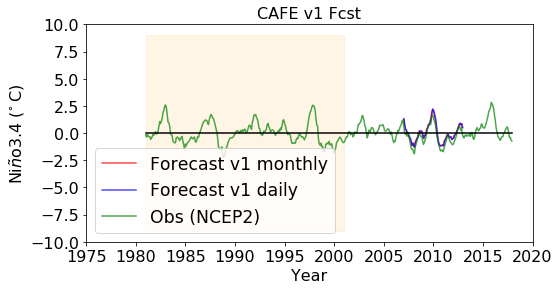

Diag= False
monthly_clim_anom: All years have 12 months.


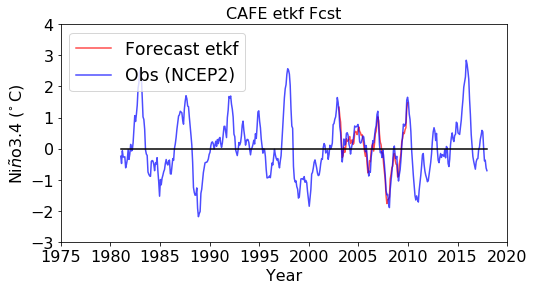

Diag= False
monthly_clim_anom: All years have 12 months.
Diag= False
monthly_clim_anom: All years have 12 months.


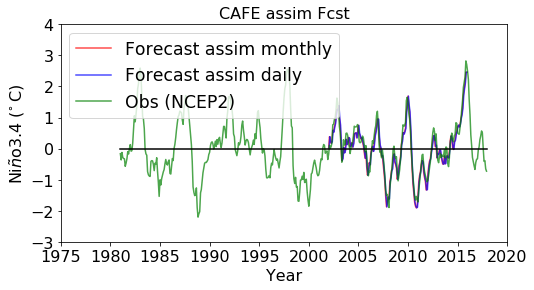

plotting...


/OSM/CBR/OA_DCFP/apps/col414/anaconda3/envs/cafepp_36_new/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Image saved to  panel1.pdf
Image saved to  panel2.pdf
Image saved to  panel3.pdf
Image saved to  panel4.pdf
Image saved to  panel5.pdf
Image saved to  panel6.pdf
END


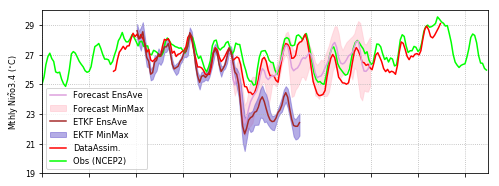

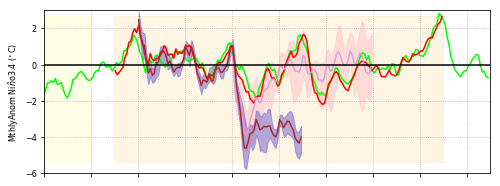

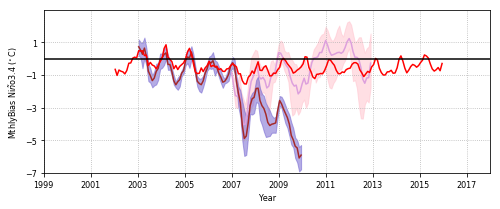

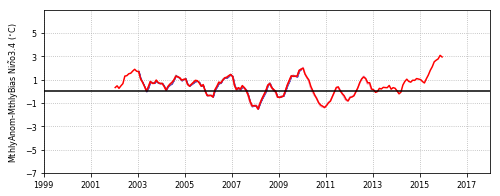

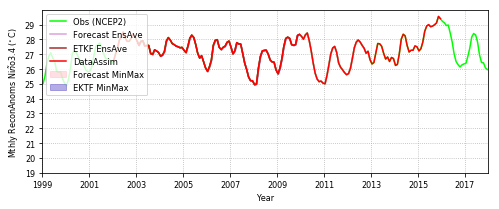

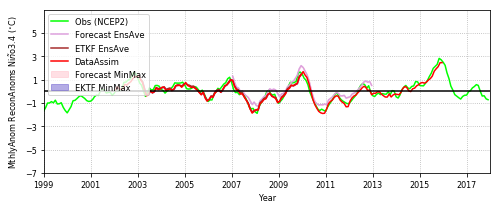

In [3]:
print('BEGIN')

Clobber=False
#Clobber=True

output_name='cafe.pkl'
input_name=output_name

output_type='pdf'
#output_type='png'

title=True
title=False #turn off title across whole set.


if(Clobber):

  print(CRED+'overwriting output PKL file and regenerating...'+CEND)
    
  nino_indice_labels=ncepr2_nino_indices.indices_label
    
  ncepr2_year_fraction_from_daily=ncepr2_file_var_from_daily.year_fraction_anomaly
  ncepr2_year_fraction_from_monthly=ncepr2_file_var_from_monthly.year_fraction_anomaly
  hadisst_year_fraction_from_monthly=hadisst_file_var.year_fraction_anomaly
  cafe_assim_year_fraction_from_daily=cafe_daily_files_assim.year_fraction_anomaly
  cafe_assim_year_fraction_from_monthly=cafe_monthly_files_assim.year_fraction_anomaly
  cafe_v1_year_fraction_from_daily=cafe_daily_files_v1.year_fraction_anomaly
  cafe_v1_year_fraction_from_monthly=cafe_monthly_files_v1.year_fraction_anomaly
  cafe_etkf_year_fraction_from_daily=cafe_daily_files_etkf.year_fraction_anomaly
  
  ncepr2_date_time_stamp_anomaly_from_daily = ncepr2_file_var_from_daily.date_time_stamp_anomaly
  ncepr2_date_time_stamp_anomaly_from_monthly = ncepr2_file_var_from_monthly.date_time_stamp_anomaly
  hadisst_date_time_stamp_anomaly_from_monthly = hadisst_file_var.date_time_stamp_anomaly
  cafe_v1_date_time_stamp_anomaly_from_daily = cafe_daily_files_v1.date_time_stamp_anomaly
  cafe_v1_date_time_stamp_anomaly_from_monthly = cafe_monthly_files_v1.date_time_stamp_anomaly
  cafe_etkf_date_time_stamp_anomaly_from_daily = cafe_daily_files_etkf.date_time_stamp_anomaly
  cafe_assim_date_time_stamp_anomaly_from_daily = cafe_daily_files_assim.date_time_stamp_anomaly
  cafe_assim_date_time_stamp_anomaly_from_monthly = cafe_monthly_files_assim.date_time_stamp_anomaly
  
  ncepr2_num_stamp_anomaly_from_daily = ncepr2_file_var_from_daily.num_stamp_anomaly
  ncepr2_num_stamp_anomaly_from_monthly = ncepr2_file_var_from_monthly.num_stamp_anomaly
  hadisst_num_stamp_anomaly_from_monthly = hadisst_file_var.num_stamp_anomaly
  cafe_v1_num_stamp_anomaly_from_daily = cafe_daily_files_v1.num_stamp_anomaly
  cafe_v1_num_stamp_anomaly_from_monthly = cafe_monthly_files_v1.num_stamp_anomaly
  cafe_etkf_num_stamp_anomaly_from_daily = cafe_daily_files_etkf.num_stamp_anomaly
  cafe_assim_num_stamp_anomaly_from_daily = cafe_daily_files_assim.num_stamp_anomaly
  cafe_assim_num_stamp_anomaly_from_monthly = cafe_monthly_files_assim.num_stamp_anomaly
  
  ncepr2_nfiles_from_daily = ncepr2_file_var_from_daily.nfiles
  ncepr2_nfiles_from_monthly = ncepr2_file_var_from_monthly.nfiles
  hadisst_nfiles_from_monthly = hadisst_file_var.nfiles
  cafe_v1_nfiles_from_daily = cafe_daily_files_v1.nfiles
  cafe_v1_nfiles_from_monthly = cafe_monthly_files_v1.nfiles
  cafe_etkf_nfiles_from_daily = cafe_daily_files_etkf.nfiles
  cafe_assim_nfiles_from_daily = cafe_daily_files_assim.nfiles
  cafe_assim_nfiles_from_monthly = cafe_monthly_files_assim.nfiles

  ncepr2_nindices_nino = ncepr2_nino_indices.nindices_nino
  hadisst_nindices_nino = hadisst_nino_indices.nindices_nino
  cafe_v1_nindices_nino = cafe_v1_nino_indices.nindices_nino
  cafe_etkf_nindices_nino = cafe_etkf_nino_indices.nindices_nino
  cafe_assim_nindices_nino = cafe_assim_nino_indices.nindices_nino
    
  ncepr2_nindices_label = ncepr2_nino_indices.indices_label
  hadisst_nindices_label = hadisst_nino_indices.indices_label
  cafe_v1_nindices_label = cafe_v1_nino_indices.indices_label
  cafe_etkf_nindices_label = cafe_etkf_nino_indices.indices_label
  cafe_assim_nindices_label = cafe_assim_nino_indices.indices_label

  ncepr2_date_time_stamp_from_daily=ncepr2_file_var_from_daily.date_time_stamp_monthly
  ncepr2_date_time_stamp_from_monthly=ncepr2_file_var_from_monthly.date_time_stamp_tfreq
  hadiist_date_time_stamp_from_monthly=hadisst_file_var.date_time_stamp_tfreq
  cafe_v1_date_time_stamp_from_daily=cafe_daily_files_v1.date_time_stamp_monthly
  cafe_v1_date_time_stamp_from_monthly=cafe_monthly_files_v1.date_time_stamp_tfreq
  cafe_etkf_date_time_stamp_from_daily=cafe_daily_files_etkf.date_time_stamp_monthly
  cafe_assim_date_time_stamp_from_daily=cafe_daily_files_assim.date_time_stamp_monthly
  cafe_assim_date_time_stamp_from_monthly=cafe_monthly_files_assim.date_time_stamp_tfreq
  
  ncepr2_time_tfreq_units_from_daily=ncepr2_file_var_from_daily.time_tfreq_units 
  ncepr2_time_tfreq_units_from_monthly=ncepr2_file_var_from_monthly.time_tfreq_units
  hadisst_time_tfreq_units_from_monthly=hadisst_file_var.time_tfreq_units
  cafe_v1_time_tfreq_units_from_daily=cafe_daily_files_v1.time_tfreq_units  
  cafe_v1_time_tfreq_units_from_monthly=cafe_monthly_files_v1.time_tfreq_units  
  cafe_etkf_time_tfreq_units_from_daily=cafe_daily_files_etkf.time_tfreq_units    
  cafe_assim_time_tfreq_units_from_daily=cafe_daily_files_assim.time_tfreq_units  
  cafe_assim_time_tfreq_units_from_monthly=cafe_monthly_files_assim.time_tfreq_units  

  ncepr2_time_tfreq_calendar_from_daily=ncepr2_file_var_from_daily.time_tfreq_calendar
  ncepr2_time_tfreq_calendar_from_monthly=ncepr2_file_var_from_monthly.time_tfreq_calendar
  hadisst_time_tfreq_calendar_from_monthly=hadisst_file_var.time_tfreq_calendar  
  cafe_v1_time_tfreq_calendar_from_daily=cafe_daily_files_v1.time_tfreq_calendar  
  cafe_v1_time_tfreq_calendar_from_monthly=cafe_monthly_files_v1.time_tfreq_calendar  
  cafe_etkf_time_tfreq_calendar_from_daily=cafe_daily_files_etkf.time_tfreq_calendar    
  cafe_assim_time_tfreq_calendar_from_daily=cafe_daily_files_assim.time_tfreq_calendar  
  cafe_assim_time_tfreq_calendar_from_monthly=cafe_monthly_files_assim.time_tfreq_calendar  
  
  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

  pkl_objects=( \
    nino_indice_labels, \
    \
    ncepr2_nino_monthly_from_daily, \
    ncepr2_nino_monthly_from_monthly, \
    hadisst_nino_monthly, \
    cafe_nino_monthly_from_daily_v1, \
    cafe_nino_monthly_from_monthly_v1, \
    cafe_nino_monthly_from_daily_etkf, \
    cafe_nino_monthly_from_daily_assim, \
    cafe_nino_monthly_from_monthly_assim, \
    \
    ncepr2_nino_monthlyanomaly_from_daily, \
    ncepr2_nino_monthlyanomaly_from_monthly, \
    hadisst_nino_monthlyanomaly, \
    cafe_nino_monthlyanomaly_from_daily_v1, \
    cafe_nino_monthlyanomaly_from_monthly_v1, \
    cafe_nino_monthlyanomaly_from_daily_etkf, \
    cafe_nino_monthlyanomaly_from_daily_assim, \
    cafe_nino_monthlyanomaly_from_monthly_assim, \
    \
    ncepr2_year_fraction_from_daily, \
    ncepr2_year_fraction_from_monthly, \
    hadisst_year_fraction_from_monthly, \
    cafe_v1_year_fraction_from_daily, \
    cafe_v1_year_fraction_from_monthly, \
    cafe_etkf_year_fraction_from_daily, \
    cafe_assim_year_fraction_from_daily, \
    cafe_assim_year_fraction_from_monthly, \
    \
    ncepr2_date_time_stamp_anomaly_from_daily, \
    ncepr2_date_time_stamp_anomaly_from_monthly, \
    hadisst_date_time_stamp_anomaly_from_monthly, \
    cafe_v1_date_time_stamp_anomaly_from_daily, \
    cafe_v1_date_time_stamp_anomaly_from_monthly, \
    cafe_etkf_date_time_stamp_anomaly_from_daily, \
    cafe_assim_date_time_stamp_anomaly_from_daily, \
    cafe_assim_date_time_stamp_anomaly_from_monthly, \
    \
    ncepr2_num_stamp_anomaly_from_daily, \
    ncepr2_num_stamp_anomaly_from_monthly, \
    hadisst_num_stamp_anomaly_from_monthly, \
    cafe_v1_num_stamp_anomaly_from_daily, \
    cafe_v1_num_stamp_anomaly_from_monthly, \
    cafe_etkf_num_stamp_anomaly_from_daily, \
    cafe_assim_num_stamp_anomaly_from_daily, \
    cafe_assim_num_stamp_anomaly_from_monthly, \
    \
    ncepr2_nfiles_from_daily, \
    ncepr2_nfiles_from_monthly, \
    hadisst_nfiles_from_monthly, \
    cafe_v1_nfiles_from_daily, \
    cafe_v1_nfiles_from_monthly, \
    cafe_etkf_nfiles_from_daily, \
    cafe_assim_nfiles_from_daily, \
    cafe_assim_nfiles_from_monthly, \
    \
    ncepr2_nindices_nino, \
    hadisst_nindices_nino, \
    cafe_v1_nindices_nino, \
    cafe_etkf_nindices_nino, \
    cafe_assim_nindices_nino, \
    \
    ncepr2_nindices_label, \
    hadisst_nindices_label, \
    cafe_v1_nindices_label, \
    cafe_etkf_nindices_label, \
    cafe_assim_nindices_label, \
    \
    ncepr2_date_time_stamp_from_daily, \
    ncepr2_date_time_stamp_from_monthly, \
    hadiist_date_time_stamp_from_monthly, \
    cafe_v1_date_time_stamp_from_daily, \
    cafe_v1_date_time_stamp_from_monthly, \
    cafe_etkf_date_time_stamp_from_daily, \
    cafe_assim_date_time_stamp_from_daily, \
    cafe_assim_date_time_stamp_from_monthly, \
    \
    ncepr2_time_tfreq_units_from_daily, \
    ncepr2_time_tfreq_units_from_monthly, \
    hadisst_time_tfreq_units_from_monthly, \
    cafe_v1_time_tfreq_units_from_daily, \
    cafe_v1_time_tfreq_units_from_monthly, \
    cafe_etkf_time_tfreq_units_from_daily, \
    cafe_assim_time_tfreq_units_from_daily, \
    cafe_assim_time_tfreq_units_from_monthly, \
    \
    ncepr2_time_tfreq_calendar_from_daily, \
    ncepr2_time_tfreq_calendar_from_monthly, \
    hadisst_time_tfreq_calendar_from_monthly, \
    cafe_v1_time_tfreq_calendar_from_daily, \
    cafe_v1_time_tfreq_calendar_from_monthly, \
    cafe_etkf_time_tfreq_calendar_from_daily, \
    cafe_assim_time_tfreq_calendar_from_daily, \
    cafe_assim_time_tfreq_calendar_from_monthly \
    )

  #raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
  #print('len(pkl_objects)=',len(pkl_objects))
  


if(os.path.exists(output_name) and Clobber):
  print(CRED+'Pkl file exists and deleting...'+CEND)
  os.remove(output_name)

  pickling_out = open(output_name, "wb")
  pickle.dump( pkl_objects, pickling_out)
  pickling_out.close()

if(os.path.exists(output_name) and not Clobber):
  print(CRED+'Pkl file exists and keeping...'+CEND)
    
print(CRED+'Pkl read from new or existing...create different output names compared to input...'+CEND)
if(os.path.exists(output_name)):
  pickling_in = open(input_name, "rb")
  nino_indice_labels, \
    ncepr2_mondata_from_daily,ncepr2_mondata_from_monthly, hadisst_mondata_from_monthly, cafe_v1_mondata_from_daily, cafe_v1_mondata_from_monthly, cafe_etkf_mondata_from_daily, cafe_assim_mondata_from_daily, cafe_assim_mondata_from_monthly, \
    \
    ncepr2_anomdata_from_daily, ncepr2_anomdata_from_monthly, hadisst_anomdata_from_monthly, cafe_v1_anomdata_from_daily, cafe_v1_anomdata_from_monthly, cafe_etkf_anomdata_from_daily, cafe_assim_anomdata_from_daily, cafe_assim_anomdata_from_monthly, \
    \
    ncepr2_time_from_daily, ncepr2_time_from_monthly, hadisst_time_from_monthly, cafe_v1_time_from_daily, cafe_v1_time_from_monthly, cafe_etkf_time_from_daily, cafe_assim_time_from_daily, cafe_assim_time_from_monthly, \
    \
    ncepr2_stamp_anomaly_from_daily, ncepr2_stamp_anomaly_from_monthly, hadisst_stamp_anomaly_from_monthly, cafe_v1_stamp_anomaly_from_daily, cafe_v1_stamp_anomaly_from_monthly, cafe_etkf_stamp_anomaly_from_daily, cafe_assim_stamp_anomaly_from_daily, cafe_assim_stamp_anomaly_from_monthly, \
    \
    ncepr2_num_stamp_anomaly_from_daily, ncepr2_num_stamp_anomaly_from_monthly, hadisst_num_stamp_anomaly_from_monthly, cafe_v1_num_stamp_anomaly_from_daily, cafe_v1_num_stamp_anomaly_from_monthly, cafe_etkf_num_stamp_anomaly_from_daily, cafe_assim_num_stamp_anomaly_from_daily, cafe_assim_num_stamp_anomaly_from_monthly, \
    \
    ncepr2_nfil_from_daily, ncepr2_nfil_from_monthly, hadiist_nfil_from_monthly, cafe_v1_nfil_from_daily, cafe_v1_nfil_from_monthly, cafe_etkf_nfil_from_daily, cafe_assim_nfil_from_daily, cafe_assim_nfil_from_monthly, \
    \
    ncepr2_nind, hadiist_nind, cafe_v1_nind, cafe_etkf_nind, cafe_assim_nind, \
    \
    ncepr2_labs, hadiist_labs, cafe_v1_labs, cafe_etkf_labs, cafe_assim_labs, \
    \
    ncepr2_stamp_from_daily, ncepr2_stamp_from_monthly, hadiist_stamp_from_monthly, cafe_v1_stamp_from_daily, cafe_v1_stamp_from_monthly, cafe_etkf_stamp_from_daily, cafe_assim_stamp_from_daily, cafe_assim_stamp_from_monthly, \
    \
    ncepr2_time_units_from_daily, ncepr2_time_units_from_monthly, hadisst_time_units_from_monthly, cafe_v1_time_units_from_daily, cafe_v1_time_units_from_monthly, cafe_etkf_time_units_from_daily, cafe_assim_time_units_from_monthly, cafe_assim_time_units_from_daily, \
    \
    ncepr2_time_calendar_from_daily, ncepr2_time_calendar_from_monthly, hadisst_time_calendar_from_monthly, cafe_v1_time_calendar_from_daily, cafe_v1_time_calendar_from_monthly,  cafe_etkf_time_calendar_from_daily, cafe_assim_time_calendar_from_daily, cafe_assim_time_calendar_from_monthly \
    = pickle.load(pickling_in)
  pickling_in.close()  
  
  #cafe_v1_time_data_from_daily
  #cafe_etkf_time_calendar_from_daily
  
print(CRED+'aligning model and observational times...'+CEND)

ncepr2_years_months_from_daily=[]
for cnt in range(ncepr2_stamp_anomaly_from_daily.size):
  ncepr2_years_months_from_daily.append(ncepr2_stamp_anomaly_from_daily[cnt].year*100+ncepr2_stamp_anomaly_from_daily[cnt].month)

ncepr2_years_months_from_monthly=[]
for cnt in range(ncepr2_stamp_anomaly_from_monthly.size):
  ncepr2_years_months_from_monthly.append(ncepr2_stamp_anomaly_from_monthly[cnt].year*100+ncepr2_stamp_anomaly_from_monthly[cnt].month)

cafe_assim_year_month1_from_daily=cafe_assim_stamp_from_daily[0].year*100+cafe_assim_stamp_from_daily[0].month
cafe_assim_year_monthN_from_daily=cafe_assim_stamp_from_daily[-1].year*100+cafe_assim_stamp_from_daily[-1].month

cafe_assim_year_month1_from_monthly=cafe_assim_stamp_from_monthly[0].year*100+cafe_assim_stamp_from_daily[0].month
cafe_assim_year_monthN_from_monthly=cafe_assim_stamp_from_monthly[-1].year*100+cafe_assim_stamp_from_daily[-1].month

cafe_v1_year_month1_from_daily=cafe_v1_stamp_from_daily[0].year*100+cafe_v1_stamp_from_daily[0].month
cafe_v1_year_monthN_from_daily=cafe_v1_stamp_from_daily[-1].year*100+cafe_v1_stamp_from_daily[-1].month

cafe_v1_year_month1_from_monthly=cafe_v1_stamp_from_monthly[0][0].year*100+cafe_v1_stamp_from_monthly[0][0].month
cafe_v1_year_monthN_from_monthly=cafe_v1_stamp_from_monthly[0][-1].year*100+cafe_v1_stamp_from_monthly[0][-1].month

cafe_etkf_year_monthN=cafe_etkf_stamp_from_daily[-1].year*100+cafe_etkf_stamp_from_daily[-1].month
cafe_etkf_year_month1=cafe_etkf_stamp_from_daily[0].year*100+cafe_etkf_stamp_from_daily[0].month

cafe_assim_first_index_from_daily=ncepr2_years_months_from_daily.index(cafe_assim_year_month1_from_daily)
cafe_assim_last_index_from_daily=ncepr2_years_months_from_daily.index(cafe_assim_year_monthN_from_daily)

cafe_assim_first_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_assim_year_month1_from_monthly)
cafe_assim_last_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_assim_year_monthN_from_monthly)

cafe_v1_first_index_from_daily=ncepr2_years_months_from_daily.index(cafe_v1_year_month1_from_monthly)
cafe_v1_last_index_from_daily=ncepr2_years_months_from_daily.index(cafe_v1_year_monthN_from_monthly)

cafe_v1_first_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_v1_year_month1_from_monthly)
cafe_v1_last_index_from_monthly=ncepr2_years_months_from_monthly.index(cafe_v1_year_monthN_from_monthly)

cafe_etkf_first_index=ncepr2_years_months_from_daily.index(cafe_etkf_year_month1)
cafe_etkf_last_index=ncepr2_years_months_from_daily.index(cafe_etkf_year_monthN)
  
#print('cafe_v1_first_index_from_daily,cafe_v1_last_index_from_daily=',cafe_v1_first_index_from_daily,cafe_v1_last_index_from_daily)
#print('cafe_v1_first_index_from_monthly,cafe_v1_last_index_from_monthly=',cafe_v1_first_index_from_monthly,cafe_v1_last_index_from_monthly)

#print(ncepr2_time[cafe_assim_first_index:cafe_assim_last_index+1])

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

#===============================================================================

print(CRED+'generating daily/monthly bias...'+CEND)

cafe_v1_bias_data_from_daily = ma.zeros((cafe_v1_last_index_from_daily-cafe_v1_first_index_from_daily+1, cafe_v1_nfil_from_daily, cafe_v1_nind),\
  dtype='f')
cafe_v1_bias_data_from_monthly = ma.zeros((cafe_v1_last_index_from_monthly-cafe_v1_first_index_from_monthly+1, cafe_v1_nfil_from_monthly, cafe_v1_nind),\
  dtype='f')
for enow in range(max_ensemble-1):
  cafe_v1_bias_data_from_daily[:,enow,:] = cafe_v1_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,:]
  cafe_v1_bias_data_from_monthly[:,enow,:] = cafe_v1_mondata_from_monthly[:,enow,:] - ncepr2_mondata_from_monthly[cafe_v1_first_index_from_monthly:cafe_v1_last_index_from_monthly+1,:]

cafe_v1_time_data_from_daily = ncepr2_time_from_daily[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1]
cafe_v1_time_data_from_monthly = ncepr2_time_from_monthly[cafe_v1_first_index_from_monthly:cafe_v1_last_index_from_monthly+1]
cafe_etkf_bias_data_from_daily = ma.zeros((cafe_etkf_last_index-cafe_etkf_first_index+1, cafe_etkf_nfil_from_daily, cafe_etkf_nind),\
  dtype='f')
for enow in range(max_ensemble-1):
  cafe_etkf_bias_data_from_daily[:,enow,:] = cafe_etkf_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_etkf_first_index:cafe_etkf_last_index+1,:]
cafe_etkf_time_data = ncepr2_time_from_daily[cafe_etkf_first_index:cafe_etkf_last_index+1]
cafe_assim_bias_data_from_daily = cafe_assim_mondata_from_daily - ncepr2_mondata_from_daily[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1,:]
cafe_assim_bias_data_from_monthly = cafe_assim_mondata_from_monthly - ncepr2_mondata_from_monthly[cafe_assim_first_index_from_monthly:cafe_assim_last_index_from_monthly+1,:]
cafe_assim_time_data_from_daily = ncepr2_time_from_daily[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1]
cafe_assim_time_data_from_monthly = ncepr2_time_from_monthly[cafe_assim_first_index_from_monthly:cafe_assim_last_index_from_monthly+1]

#===============================================================================

print(CRED+'generating anom MINUS daily/monthly bias...'+CEND)

cafe_v1_anomMbias_data_from_daily = ma.zeros((cafe_v1_last_index_from_daily-cafe_v1_first_index_from_daily+1, cafe_v1_nfil_from_daily, cafe_v1_nind),\
  dtype='f')
cafe_v1_anomMbias_data_from_monthly = ma.zeros((cafe_v1_last_index_from_monthly-cafe_v1_first_index_from_monthly+1, cafe_v1_nfil_from_monthly, cafe_v1_nind),\
  dtype='f')
for enow in range(max_ensemble-1):
  cafe_v1_anomMbias_data_from_daily[:,enow,:] = cafe_v1_anomdata_from_daily[:,enow,:] - (cafe_v1_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_v1_first_index_from_daily:cafe_v1_last_index_from_daily+1,:])
  cafe_v1_anomMbias_data_from_monthly[:,enow,:] = cafe_v1_anomdata_from_monthly[:,enow,:] - (cafe_v1_mondata_from_monthly[:,enow,:] - ncepr2_mondata_from_monthly[cafe_v1_first_index_from_monthly:cafe_v1_last_index_from_monthly+1,:])
cafe_etkf_anomMbias_data = ma.zeros((cafe_etkf_last_index-cafe_etkf_first_index+1, cafe_etkf_nfil_from_daily, cafe_etkf_nind),\
  dtype='f')
for enow in range(max_ensemble-1):
  cafe_etkf_anomMbias_data[:,enow,:] = cafe_etkf_anomdata_from_daily[:,enow,:] - (cafe_etkf_mondata_from_daily[:,enow,:] - ncepr2_mondata_from_daily[cafe_etkf_first_index:cafe_etkf_last_index+1,:])
cafe_assim_anomMbias_data_from_daily = cafe_assim_anomdata_from_daily[:,:] - (cafe_assim_mondata_from_daily[:,:] - ncepr2_mondata_from_daily[cafe_assim_first_index_from_daily:cafe_assim_last_index_from_daily+1,:])
cafe_assim_anomMbias_data_from_monthly = cafe_assim_anomdata_from_monthly[:,:] - (cafe_assim_mondata_from_monthly[:,:] - ncepr2_mondata_from_monthly[cafe_assim_first_index_from_monthly:cafe_assim_last_index_from_monthly+1,:])

# anom minus bias = mod_mon - mod_clim,n + ncep_mon - mod_mon = ncep_mon - mod_clim,n: n is repeating monthly clim for every year n.
#===============================================================================

print(CRED+'reconstructing model data from daily/monthly data and bias...'+CEND)

cafe_v1_reconstructed_from_daily = cafe_v1_mondata_from_daily - cafe_v1_bias_data_from_daily
cafe_v1_reconstructed_from_monthly = cafe_v1_mondata_from_monthly - cafe_v1_bias_data_from_monthly
cafe_etkf_reconstructed_from_daily = cafe_etkf_mondata_from_daily - cafe_etkf_bias_data_from_daily
cafe_assim_reconstructed_from_daily = cafe_assim_mondata_from_daily - cafe_assim_bias_data_from_daily
cafe_assim_reconstructed_from_monthly = cafe_assim_mondata_from_monthly - cafe_assim_bias_data_from_monthly

# reconstructed = mod_mon - mod_mon - ncep_mon = ncep_mon

#===============================================================================

# input_datas=(ncepr2_mondata[:,nino_index_k],)
# input_xvals=(ncepr2_time,)

# input_datas = input_datas + (cafe_assim_reconstructed[:,nino_index_k],)
# input_xvals = input_xvals + (cafe_assim_time_data,)

# plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
#   title='CAFE Fcst', \
#   units='$\!^\circ$C', \
#   xlab='Year', \
#   ylab=cafe_etkf_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
#   zero2=True, \
#   reverse_xaxis=False, \
#   reverse_yaxis=False, \
#   line_colors=['red','blue'], \
#   line_labels=['Obs (NCEP2)','Assim'], \
#   legend_position='best', \
#   xysize=(10,5))

#===============================================================================

#This was old way of calculating anomalies, but I have modified n_data_funcs to have a 'dummy_mode'. This tricks it to doing monthly_clim_anom functionality by providing minimum of self.data objects.
#this old way was problematic, when PKLing, as needed to keep original n_data_funcs instances, which cannot be PKLed.

# cbeg=2007
# cend=2012
# abeg=2007
# aend=2012

# cafe_nino_monthlyclimatology_from_daily_v1_reconstructed,cafe_nino_monthlyanomaly_from_daily_v1_reconstructed=cafe_daily_files_v1.monthly_clim_anom( \
#     Diag=True, input=cafe_v1_reconstructed, AnnOut=False, ZeroClim=False, \
#     cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)


# cbeg=2003
# cend=2009
# abeg=2003
# aend=2009
  
# cafe_nino_monthlyclimatology_from_daily_etkf_reconstructed,cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed=cafe_daily_files_etkf.monthly_clim_anom( \
#     Diag=True, input=cafe_etkf_reconstructed, AnnOut=False, ZeroClim=False, \
#     cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

# input_datas=(ncepr2_nino_monthlyanomaly[:,nino_index_k],)
# input_xvals=(ncepr2_year_fraction,)

# input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_v1_reconstructed[:,:,nino_index_k],axis=1),)
# input_xvals = input_xvals + (cafe_v1_time_data,)

# input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed[:,:,nino_index_k],axis=1),)
# input_xvals = input_xvals + (cafe_etkf_time_data,)

# plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
#   title='CAFE Fcst', \
#   units='$\!^\circ$C', \
#   xlab='Year', \
#   ylab=cafe_etkf_nino_indices.indices_label[nino_index_k]+' ('+'$\!^\circ$C'+')', \
#   zero2=True, \
#   reverse_xaxis=False, \
#   reverse_yaxis=False, \
#   line_colors=['red','blue','green'], \
#   line_labels=['Obs (NCEP2)','Forecast','ETKF'], \
#   legend_position='best', \
#   xysize=(10,5))

#===============================================================================

print(CRED+'generating model anomalies from reconstructed data...'+CEND)

#The new approach:

cbeg=2007
cend=2012
abeg=2007
aend=2012

test_v1_monthly = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_v1_stamp_anomaly_from_monthly, cafe_v1_num_stamp_anomaly_from_monthly, \
  cafe_v1_time_units_from_monthly, cafe_v1_time_calendar_from_monthly)) #I think boolean for dummy_mode should be False but seems to work.

cafe_nino_monthlyclimatology_from_monthly_v1_reconstructed_test, cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test= \
  test_v1_monthly.monthly_clim_anom( \
  Diag=False, input=cafe_v1_reconstructed_from_monthly, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

test_v1_daily = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_v1_stamp_anomaly_from_daily, cafe_v1_num_stamp_anomaly_from_daily, \
  cafe_v1_time_units_from_daily, cafe_v1_time_calendar_from_daily))

cafe_nino_monthlyclimatology_from_daily_v1_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_v1_reconstructed_test= \
  test_v1_daily.monthly_clim_anom( \
  Diag=False, input=cafe_v1_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

input_xvals = (cafe_v1_time_data_from_monthly,)
input_datas = (np.average(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,:,nino_index_k],axis=1),)

input_xvals = input_xvals + (cafe_v1_time_data_from_daily,)
input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_v1_reconstructed_test[:,:,nino_index_k],axis=1),)

input_xvals = input_xvals + (ncepr2_time_from_monthly,)
input_datas = input_datas + (ncepr2_anomdata_from_monthly[:,nino_index_k],)

plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
  title='CAFE v1 Fcst', \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab=cafe_v1_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue','green'], \
  line_labels=['Forecast v1 monthly','Forecast v1 daily','Obs (NCEP2)'], \
  legend_position='best', \
#  vertical_lines=([1980, 2005],[-10,5],['black','orange'],['--','--']), \
#  vertical_lines=([1980, 2005],['black','orange'],['--',':']), \
  ylim=[-10,10], \
  box_overlay=([[1981,2000+1,-5,5]],['orange'],[0.1]), \
#  box_overlay=([[1980,2005,-5,5],[2006,2008,-2,2]],['orange','yellow'],[0.1,0.1]), \
  xysize=(8,4))


###

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))

cbeg=2003
cend=2009
abeg=2003
aend=2009

test_etkf_daily = n_data_funcs(Diag=False, input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_etkf_stamp_anomaly_from_daily, cafe_etkf_num_stamp_anomaly_from_daily, \
  cafe_etkf_time_units_from_daily, cafe_etkf_time_calendar_from_daily))

cafe_nino_monthlyclimatology_from_daily_etkf_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test= \
  test_etkf_daily.monthly_clim_anom( \
  Diag=False, input=cafe_etkf_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

input_xvals = (cafe_etkf_time_data,)
input_datas = (np.average(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,:,nino_index_k],axis=1),)

input_datas = input_datas + (ncepr2_anomdata_from_daily[:,nino_index_k],)
input_xvals = input_xvals + (ncepr2_time_from_daily,)

plot_xy(Diag=False,input_data=input_datas,input_xvals=input_xvals, \
  title='CAFE etkf Fcst', \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab=cafe_etkf_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue'], \
  line_labels=['Forecast etkf','Obs (NCEP2)'], \
  legend_position='best', \
  xysize=(8,4))

cbeg=2002
cend=2015
abeg=2002
aend=2015

test_assim_monthly = n_data_funcs(Diag=False,input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_assim_stamp_anomaly_from_monthly, cafe_assim_num_stamp_anomaly_from_monthly, \
  cafe_assim_time_units_from_monthly, cafe_assim_time_calendar_from_monthly)) #I think boolean for dummy_mode should be False but seems to work.

cafe_nino_monthlyclimatology_from_monthly_assim_reconstructed_test, cafe_nino_monthlyanomaly_from_monthly_assim_reconstructed_test= \
  test_assim_monthly.monthly_clim_anom( \
  Diag=False, input=cafe_assim_reconstructed_from_monthly, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

test_assim_daily = n_data_funcs(Diag=False,input_files=None, input_var_name=None, \
  dummy_mode=(True, cafe_assim_stamp_anomaly_from_daily, cafe_assim_num_stamp_anomaly_from_daily, \
  cafe_assim_time_units_from_monthly, cafe_assim_time_calendar_from_monthly))

cafe_nino_monthlyclimatology_from_daily_assim_reconstructed_test, cafe_nino_monthlyanomaly_from_daily_assim_reconstructed_test= \
  test_assim_daily.monthly_clim_anom( \
  Diag=False, input=cafe_assim_reconstructed_from_daily, AnnOut=False, ZeroClim=False, \
  cbeg=cbeg, cend=cend, abeg=abeg, aend=aend)

input_xvals = (cafe_assim_time_data_from_monthly,)
input_datas = (cafe_nino_monthlyanomaly_from_monthly_assim_reconstructed_test[:,nino_index_k],)

input_xvals = input_xvals + (cafe_assim_time_data_from_daily,)
input_datas = input_datas + (cafe_nino_monthlyanomaly_from_daily_assim_reconstructed_test[:,nino_index_k],)

input_xvals = input_xvals + (ncepr2_time_from_monthly,)
input_datas = input_datas + (ncepr2_anomdata_from_monthly[:,nino_index_k],)


plot_xy(Diag=False, input_data=input_datas, input_xvals=input_xvals, \
  title='CAFE assim Fcst', \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab=cafe_assim_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  line_colors=['red','blue','green'], \
  line_labels=['Forecast assim monthly','Forecast assim daily','Obs (NCEP2)'], \
  legend_position='best', \
  xysize=(8,4))

#raise SystemExit('STOP!:'+__file__+' line number: '+str(inspect.stack()[0][2]))
  
#===============================================================================

# print('len(nino_indice_labels)=',len(nino_indice_labels))

# print('ncepr2_mondata.shape=',ncepr2_mondata.shape)
# print('hadisst_mondata.shape=',hadisst_mondata.shape)
# print('cafe_assim_mondata.shape=',cafe_assim_mondata.shape)
# print('cafe_v1_mondata.shape=',cafe_v1_mondata.shape)
# print('cafe_etkf_mondata.shape=',cafe_etkf_mondata.shape)

# print('ncepr2_anomdata.shape=',ncepr2_anomdata.shape)
# print('hadisst_anomdata.shape=',hadisst_anomdata.shape)
# print('cafe_assim_anomdata.shape=',cafe_assim_anomdata.shape)
# print('cafe_v1_anomdata.shape=',cafe_v1_anomdata.shape)
# print('cafe_etkf_anomdata.shape=',cafe_etkf_anomdata.shape)

# print('ncepr2_time.shape=',ncepr2_time.shape)
# print('hadisst_time.shape=',hadisst_time.shape)
# print('cafe_assim_time.shape=',cafe_assim_time.shape)
# print('cafe_v1_time.shape=',cafe_v1_time.shape)
# print('cafe_etkf_time.shape=',cafe_etkf_time.shape)

#===============================================================================

print(CRED+'plotting...'+CEND)

input_xvals = (ncepr2_time_from_monthly,)
#input_xvals = input_xvals + (hadisst_time,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)

input_mondatas = (ncepr2_mondata_from_monthly[:,nino_index_k],)
#input_mondatas = input_mondatas + (hadisst_mondata[:,nino_index_k],)
input_mondatas = input_mondatas + (cafe_assim_mondata_from_monthly[:,nino_index_k],)
input_mondatas = input_mondatas + (np.min(cafe_v1_mondata_from_monthly[:,:,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.max(cafe_v1_mondata_from_monthly[:,:,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.average(cafe_v1_mondata_from_monthly[:,:,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.min(cafe_etkf_mondata_from_daily[:,:,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.max(cafe_etkf_mondata_from_daily[:,:,nino_index_k],axis=1),)
input_mondatas = input_mondatas + (np.average(cafe_etkf_mondata_from_daily[:,:,nino_index_k],axis=1),)

#monthly full
ylim=[19,30]
yticks=np.arange(19,30,2)

if(title): 
  title_here='plot1' 
else: 
  title_here=''
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_mondatas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
#  xlab='Year', \
  ylab='Mthly '+ncepr2_labs[nino_index_k]+' ($\!^\circ$C)', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='lower left', \
  line_colors=['lime','red','pink','plum','SlateBlue','brown'], \
  line_alphas=[1.0,1.0,0.5,1.0,0.5,1.0], \
  line_labels=['Obs (NCEP2)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
  fill_between=[0,1,2,2,3,4,4,5], \
  legend_item_reorder = [2,4,3,5,1,0], \
#  legend_item_reorder = [3,5,4,6,2,0,1], \
#   fill_between=[0,1,2,3,3,4,5,5,6], \
#   line_colors=['red','lime','cyan','pink','plum','SlateBlue','brown'], \
#   line_alphas=[1.0,1.0,1.0,0.3,1.0,0.3,1.0], \
#   line_labels=['Obs (NCEP2)','Obs (HadISST)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
#   legend_item_reorder = [3,5,4,6,2,0,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  grid_linestyle='dotted', \
  xticks_lab_off=True, \
#  vertical_lines=([cbeg_assim, cend_assim+1],['red','red'],[':',':']), \
  output=('panel1',output_type)
  )

#===============================================================================

#monthly anomalies

input_xvals = (ncepr2_time_from_monthly,)
#input_xvals = input_xvals + (hadisst_time,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)

input_anomdatas = (ncepr2_anomdata_from_monthly[:,nino_index_k],)
#input_anomdatas = input_anomdatas + (hadisst_anomdata[:,nino_index_k],)
input_anomdatas = input_anomdatas + (cafe_assim_anomdata_from_monthly[:,nino_index_k],)
input_anomdatas = input_anomdatas + (np.min(cafe_v1_anomdata_from_monthly[:,:,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.max(cafe_v1_anomdata_from_monthly[:,:,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.average(cafe_v1_anomdata_from_monthly[:,:,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.min(cafe_etkf_anomdata_from_daily[:,:,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.max(cafe_etkf_anomdata_from_daily[:,:,nino_index_k],axis=1),)
input_anomdatas = input_anomdatas + (np.average(cafe_etkf_anomdata_from_daily[:,:,nino_index_k],axis=1),)

ylim=[-6,3]
yticks=np.arange(-6,3,2)

if(title): 
  title_here='plot2' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_anomdatas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
# xlab='Year', \
  ylab='MthlyAnom '+ncepr2_labs[nino_index_k]+' ($\!^\circ$C)', \
  zero2=True, \
  reverse_xaxis=False, \
  reverse_yaxis=False, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='lower center', \
  line_colors=['lime','red','pink','plum','SlateBlue','brown'], \
  line_alphas=[1.0,1.0,0.5,1.0,0.5,1.0], \
  line_labels=['Obs (NCEP2)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve'], \
  fill_between=[0,1,2,2,3,4,4,5], \
  legend_item_reorder = [2,4,3,5,1,0], \
#   line_colors=['red','lime','cyan','pink','plum','SlateBlue','brown'], \
#   line_alphas=[1.0,1.0,1.0,0.3,1.0,0.3,1.0], \
#   line_labels=['Obs (NCEP2)','Obs (HadISST)','DataAssim.','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF'], \
#   fill_between=[0,1,2,3,3,4,5,5,6], \
#   legend_item_reorder = [0,1,2,3,4,5,6], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=True, \
  grid_linestyle='dotted', \
  xticks_lab_off=True, \
#  vertical_lines=([1980, 2005],[-10,5],['black','orange'],['--','--']), \
#  vertical_lines=([1980, 2005],['black','orange'],['--',':']), \
#  ylim=[-5,5], \
#   vertical_lines=([2002, 2015+1, 1981, 2000+1],['red','red','green','green'],[':',':',':',':']), \
  box_overlay=([[2002, 2015+1,-5,5],[1981, 2000+1,-2,2]],['orange','yellow'],[0.1,0.1]), \
  output=('panel2',output_type)
  )

#===============================================================================

input_xvals = (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

input_datas = (np.min(cafe_v1_bias_data_from_monthly[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_v1_bias_data_from_monthly[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_v1_bias_data_from_monthly[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (np.min(cafe_etkf_bias_data_from_daily[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_etkf_bias_data_from_daily[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_etkf_bias_data_from_daily[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (cafe_assim_bias_data_from_monthly[:,nino_index_k],)

if(title): 
  title_here='plot3' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='MthlyBias '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=[-7,3], \
  fill_between=[0,0,1,2,2,3,4], \
  xticks=np.arange(1999,2018,2), \
  yticks=np.arange(-7,3,2), \
  legend_position='upper right', \
  line_colors=['pink','plum','SlateBlue','brown','red'], \
  line_alphas=[0.5,1.0,0.5,1.0,1.0], \
  line_labels=['Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [3,0,2,4,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  grid_linestyle='dotted', \
  legend_off=True, \
  xticks_lab_off=False, \
  output=('panel3',output_type)
  )

#===============================================================================

input_xvals = (cafe_v1_time_data_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

#normal
v1_scale=1.0
etkf_scale=1.0
assim_scale=1.0

#test
# v1_scale=0.0
# etkf_scale=1.2
# assim_scale=1.0

input_datas = (np.min(cafe_v1_anomMbias_data_from_monthly[:,:,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.max(cafe_v1_anomMbias_data_from_monthly[:,:,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.average(cafe_v1_anomMbias_data_from_monthly[:,:,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.min(cafe_etkf_anomMbias_data[:,:,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.max(cafe_etkf_anomMbias_data[:,:,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.average(cafe_etkf_anomMbias_data[:,:,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (cafe_assim_anomMbias_data_from_monthly[:,nino_index_k]*assim_scale,)

if(title): 
  title_here='plot4' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
#  xlab='Year', \
  ylab='MthlyAnom-MthlyBias '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=[-7,7], \
  fill_between=[0,0,1,2,2,3,4], \
  xticks=np.arange(1999,2018,2), \
  yticks=np.arange(-7,7,2), \
  legend_position='best', \
  line_colors=['pink','plum','SlateBlue','brown','red'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0], \
  line_labels=['Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [0,1,2,3,4], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=True, \
  grid_linestyle='dotted', \
  output=('panel4',output_type)
  )

#===============================================================================

input_xvals = (ncepr2_time_from_daily,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

input_datas = (ncepr2_mondata_from_monthly[:,nino_index_k],)
input_datas = input_datas + (np.min(cafe_v1_reconstructed_from_monthly[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_v1_reconstructed_from_monthly[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_v1_reconstructed_from_monthly[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (np.min(cafe_etkf_reconstructed_from_daily[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (np.max(cafe_etkf_reconstructed_from_daily[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (np.average(cafe_etkf_reconstructed_from_daily[:,:,nino_index_k],axis=1),)
input_datas = input_datas + (cafe_assim_reconstructed_from_monthly[:,nino_index_k],)

#print('ncepr2_time=',ncepr2_time)
#print('cafe_assim_time_data=',cafe_assim_time_data)

ylim=[19,30]
yticks=np.arange(19,30,1)

if(title): 
  title_here='plot5' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='Mthly ReconAnoms '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=ylim, \
  xticks=np.arange(1999,2018,2), \
  yticks=yticks, \
  legend_position='upper left', \
  fill_between=[0,1,1,2,3,3,4,5], \
  line_colors=['lime','pink','plum','SlateBlue','brown','red'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0,1.0], \
  line_labels=['Obs (NCEP2)','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [0,1,2,3,4,5], \
#   line_colors=['red','cyan'], \
#   line_alphas=[1.0,1.0], \
#   line_labels=['Obs (NCEP2)','DataAssim'], \
#   legend_item_reorder = [0,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=False, \
  grid_linestyle='dotted', \
  output=('panel5',output_type)
  )

#===============================================================================

#normal
v1_scale=1.0
etkf_scale=1.0
assim_scale=1.0

#test
# v1_scale=0.0
# etkf_scale=0.0
# assim_scale=1.0

input_xvals = (ncepr2_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_v1_time_from_monthly,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_etkf_time_from_daily,)
input_xvals = input_xvals + (cafe_assim_time_from_monthly,)

input_datas = (ncepr2_anomdata_from_monthly[:,nino_index_k],)
input_datas = input_datas + (np.min(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,:,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.max(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,:,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_monthly_v1_reconstructed_test[:,:,nino_index_k],axis=1)*v1_scale,)
input_datas = input_datas + (np.min(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,:,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.max(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,:,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (np.average(cafe_nino_monthlyanomaly_from_daily_etkf_reconstructed_test[:,:,nino_index_k],axis=1)*etkf_scale,)
input_datas = input_datas + (cafe_nino_monthlyanomaly_from_monthly_assim_reconstructed_test[:,nino_index_k]*assim_scale,)

#print('ncepr2_time=',ncepr2_time)
#print('cafe_assim_time_data=',cafe_assim_time_data)

if(title): 
  title_here='plot6' 
else: 
  title_here=''
  
plot_xy(Diag=False, \
  title=title_here, \
  input_data=input_datas, \
  input_xvals=input_xvals, \
  units='$\!^\circ$C', \
  xlab='Year', \
  ylab='MthlyAnom ReconAnoms '+ncepr2_labs[nino_index_k]+' ('+'$\!^\circ$C'+')', \
  zero2=True, \
  grid=True, \
  xysize=(8,3), \
  xlim=[1999,2018], \
  ylim=[-7,7], \
  xticks=np.arange(1999,2018,2), \
  yticks=np.arange(-7,7,2), \
  legend_position='upper left', \
  fill_between=[0,1,1,2,3,3,4,5], \
  line_colors=['lime','pink','plum','SlateBlue','brown','red'], \
  line_alphas=[1.0,0.5,1.0,0.5,1.0,1.0], \
  line_labels=['Obs (NCEP2)','Forecast MinMax','Forecast EnsAve','EKTF MinMax','ETKF EnsAve','DataAssim'], \
  legend_item_reorder = [0,1,2,3,4,5], \
#   line_colors=['red','cyan'], \
#   line_alphas=[1.0,1.0], \
#   line_labels=['Obs (NCEP2)','DataAssim'], \
#   legend_item_reorder = [0,1], \
  xlab_fontsize=8.0, \
  ylab_fontsize=8.0, \
  xticks_fontsize=8.0, \
  yticks_fontsize=8.0, \
  legend_fontsize='small', \
  legend_off=False, \
  grid_linestyle='dotted', \
  output=('panel6',output_type)
  )

#===============================================================================

print('END')